In [413]:
from xml.dom import minidom
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
matplotlib.style.use('ggplot')
%matplotlib inline

mydoc = minidom.parse("electric_power.xml")

In [414]:
v, d = [], []

for i in mydoc.getElementsByTagName("VALUE"):
    v.append(i.firstChild.data)
    
for i in mydoc.getElementsByTagName("DATE"):
    d.append(i.firstChild.data)

df = pd.DataFrame({'VALUE': v, 'DATE': d})
df['VALUE'] = pd.to_numeric(df['VALUE'])
df

,VALUE,DATE
0,243887.0,01.01.2009 0:00:00.000000
1,243068.0,01.01.2009 0:00:00.000000
2,242266.0,01.01.2009 0:00:00.000000
3,242659.0,01.01.2009 0:00:00.000000
4,243724.0,01.01.2009 0:00:00.000000
...,...,...
17513,371835.0,31.12.2010 0:00:00.000000
17514,370674.0,31.12.2010 0:00:00.000000
17515,369646.0,31.12.2010 0:00:00.000000
17516,365917.0,31.12.2010 0:00:00.000000


In [415]:
df = df.groupby('DATE').sum().reset_index()
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values(by='DATE')
df = df.reset_index()

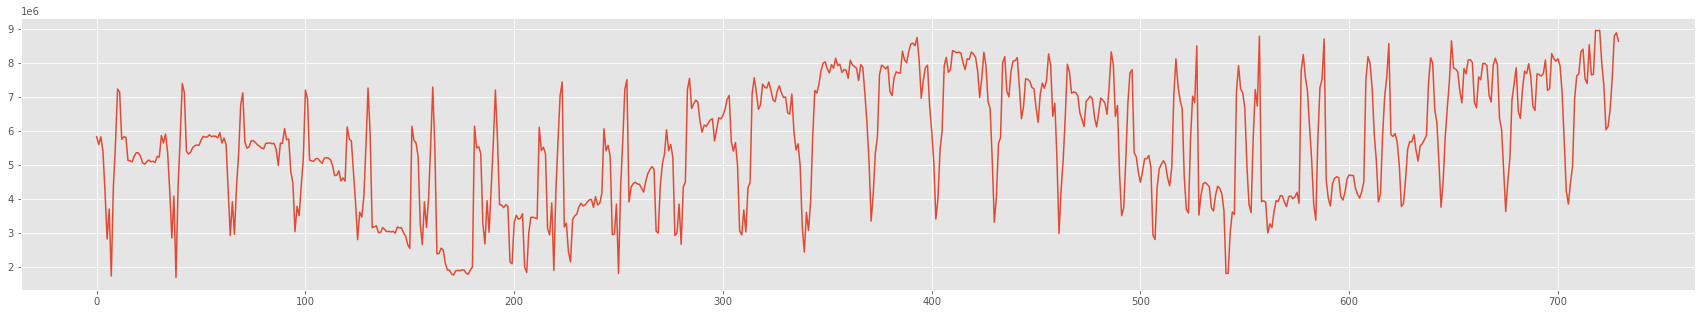

In [416]:
fig = plt.figure(figsize=(30, 5))
df['VALUE'].plot()

In [417]:
# Создаём последовательсть месяцев (дней?)
new_dates = pd.date_range('2011-01-01', '2011-01-07')
# Приводим df['DATE'] к типу Index, объединяем с 7 днями, полученными на предыдущем шаге
new_dates = pd.Index(df['DATE']) | new_dates
# Создаём датафрейм из одной колонки с расширенным набором дат
df2 = pd.DataFrame({'DATE': new_dates})
# Объединяем два датафрейма по колонке 'date'.
df = pd.merge(df, df2, on='DATE', how='right')
df

,index,DATE,VALUE
0,0.0,2009-01-01,5830312.0
1,2.0,2009-01-02,5597619.0
2,4.0,2009-01-03,5825879.0
3,6.0,2009-01-04,5410538.0
4,8.0,2009-01-05,4225877.0
...,...,...,...
732,NaN,2011-01-03,NaN
733,NaN,2011-01-04,NaN
734,NaN,2011-01-05,NaN
735,NaN,2011-01-06,NaN


Создадим регрессионную переменную day_num -- порядковый номер дня

In [380]:
df['day_num'] = range(1, len(df) + 1)
df['day_num']

0        1
1        2
2        3
3        4
4        5
      ... 
732    733
733    734
734    735
735    736
736    737
Name: day_num, Length: 737, dtype: int32

In [382]:
# 12 колонок month_1, month_2..., в которые поместим индикаторы соответствующего месяца.
for x in range(1, 13):
    df['month_' + str(x)] = df['DATE'].dt.month == x

# 365 колонок day_1, day_2 ..., в которые поместим индикаторы соответствующего дня в  году. 
for x in range(1, 366):
    df['day_' + str(x)] = df['DATE'].dt.dayofyear == x
     
# 31 колонка , в которые поместим индикаторы соответствующего дня в месяце. 
for x in range(1, 32):
    df['dayofmonth_' + str(x)] = df['DATE'].dt.day == x

# 7 колонок , в которые поместим индикаторы соответствующего дня в неделе.
for x in range(1, 8):
    df['dayofweek_' + str(x)] = df['DATE'].dt.dayofweek == x


In [367]:
day_columns = ['day_' + str(x) for x in range(1, 366)]
month_columns = ['month_' + str(x) for x in range(1, 13)]
dayofweek_columns = ['dayofweek_' + str(x) for x in range(0, 7)]
dayofmonth_columns = ['dayofmonth_' + str(x) for x in range(1, 32)]

# Создадим объекты матрицу X и вектор y для обучения модели
X = df[['day_num'] + day_columns + month_columns + dayofweek_columns + dayofmonth_columns]
y = df['VALUE']

# Оставим только те строчки, у которых известны значения y (с номером < 730)
X1 = x[x.index < 730]
y1 = y[y.index < 730]

In [368]:
model = LinearRegression()
model.fit(X1, y1)

LinearRegression()

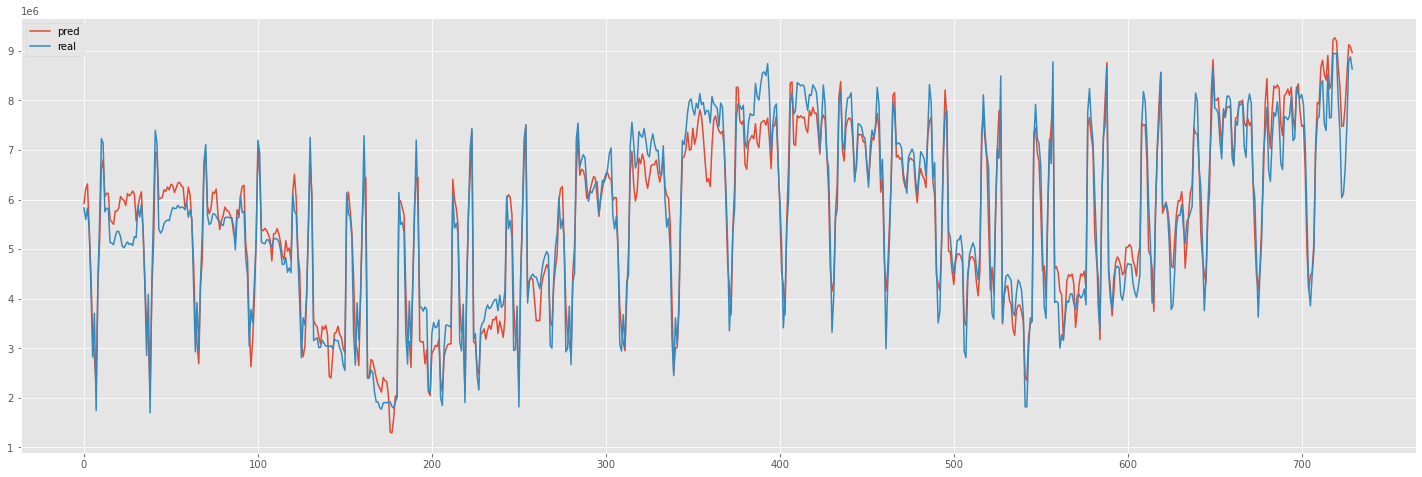

In [375]:
pred = pd.DataFrame({
    'pred': model.predict(X1),
    'real': y1})
pred.plot(figsize=(25, 8))

Теперь построим предсказание для всей матрицы X, включая неизвестные 7 дней.

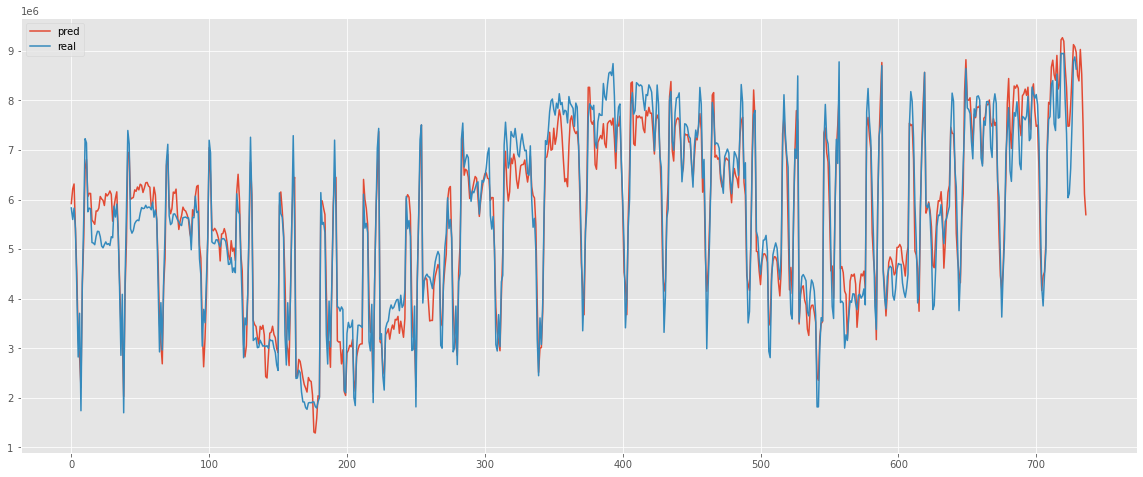

In [386]:
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot(figsize=(20, 8))

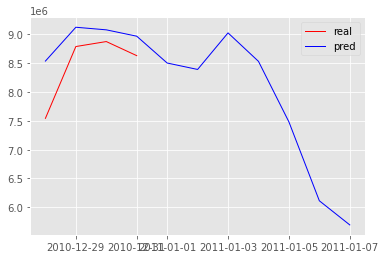

In [392]:
d1=df[df.index > 725]
X2 = X[X.index > 725]
y2 = df[df.index > 725]['VALUE']
plt.plot(d1['DATE'], y2, 'r', linewidth=1, label='real')
plt.plot(d1['DATE'], model.predict(X2), 'b', linewidth=1, label='pred')
plt.legend()
plt.show()

In [378]:
print('R^2 =', model.score(X1, y1))

R^2 = 0.9286663996859692
